imports

In [12]:


import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from difflib import get_close_matches
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from IPython.display import display

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)


Load datasets

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
confirmed = pd.read_csv('/content/drive/MyDrive/covid19_Confirmed_dataset.csv')
deaths    = pd.read_csv('/content/drive/MyDrive/covid19_deaths_dataset.csv')
happiness = pd.read_csv('/content/drive/MyDrive/worldwide_happiness_report.csv')
print("Confirmed cols:", confirmed.columns[:10])
print("Deaths cols:", deaths.columns[:10])
print("Happiness cols:", happiness.columns)


Confirmed cols: Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20'],
      dtype='object')
Deaths cols: Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20'],
      dtype='object')
Happiness cols: Index(['Overall rank', 'Country or region', 'Score', 'GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption'],
      dtype='object')


Reshape wide → long (common Johns Hopkins format)

In [18]:
date_pattern = re.compile(r'^(\d{1,2}/\d{1,2}/\d{2,4})$')

def detect_date_columns(df):
    return [c for c in df.columns if isinstance(c, str) and date_pattern.match(c)]

def melt_if_wide(df, value_name):
    date_cols = detect_date_columns(df)
    if len(date_cols) >= 2:
        id_cols = [c for c in ['Province/State','Country/Region','Lat','Long'] if c in df.columns]
        long = df.melt(id_vars=id_cols, value_vars=date_cols,
                       var_name='Date', value_name=value_name)
        long['Date'] = pd.to_datetime(long['Date'], errors='coerce')
        return long
    else:
        return df

confirmed_long = melt_if_wide(confirmed, 'Confirmed')
deaths_long    = melt_if_wide(deaths, 'Deaths')

display(confirmed_long.head())
display(deaths_long.head())


/tmp/ipython-input-2418276636.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  long['Date'] = pd.to_datetime(long['Date'], errors='coerce')
/tmp/ipython-input-2418276636.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  long['Date'] = pd.to_datetime(long['Date'], errors='coerce')


,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0


,Province/State,Country/Region,Lat,Long,Date,Deaths
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0


Aggregate by Country + Date

In [19]:
# Standardize column names
for df in [confirmed_long, deaths_long]:
    if 'Country/Region' in df.columns:
        df.rename(columns={'Country/Region':'Country'}, inplace=True)

agg_c = confirmed_long.groupby(['Country','Date'])['Confirmed'].sum().reset_index()
agg_d = deaths_long.groupby(['Country','Date'])['Deaths'].sum().reset_index()

covid = agg_c.merge(agg_d, on=['Country','Date'], how='left').fillna(0)
covid['Year'] = covid['Date'].dt.year
covid['Daily_Confirmed'] = covid.groupby('Country')['Confirmed'].diff().fillna(covid['Confirmed'])
covid['CFR_percent'] = np.where(covid['Confirmed']>0, covid['Deaths']/covid['Confirmed']*100, np.nan)

covid.head()


,Country,Date,Confirmed,Deaths,Year,Daily_Confirmed,CFR_percent
0,Afghanistan,2020-01-22,0,0,2020,0.0,NaN
1,Afghanistan,2020-01-23,0,0,2020,0.0,NaN
2,Afghanistan,2020-01-24,0,0,2020,0.0,NaN
3,Afghanistan,2020-01-25,0,0,2020,0.0,NaN
4,Afghanistan,2020-01-26,0,0,2020,0.0,NaN


Clean Happiness dataset

In [20]:
h = happiness.copy()
if 'Country or region' in h.columns:
    h.rename(columns={'Country or region':'Country'}, inplace=True)
if 'Score' in h.columns:
    h.rename(columns={'Score':'Happiness_Score'}, inplace=True)

h.head()


,Overall rank,Country,Happiness_Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


Merge COVID + Happiness

In [21]:
covid_year = covid.groupby(['Country','Year']).agg(
    Confirmed_total=('Confirmed','max'),
    Deaths_total=('Deaths','max'),
    CFR_mean=('CFR_percent','mean')
).reset_index()

merged = covid_year.merge(h, on='Country', how='left')
print("Merged shape:", merged.shape)
merged.head()


Merged shape: (187, 13)


,Country,Year,Confirmed_total,Deaths_total,CFR_mean,Overall rank,Happiness_Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,Afghanistan,2020,2171,64,1.775427,154.0,3.203,0.350,0.517,0.361,0.000,0.158,0.025
1,Albania,2020,773,31,4.236719,107.0,4.719,0.947,0.848,0.874,0.383,0.178,0.027
2,Algeria,2020,4006,450,8.244773,88.0,5.211,1.002,1.160,0.785,0.086,0.073,0.114
3,Andorra,2020,745,42,2.567593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,2020,27,2,10.171027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Visualization examples

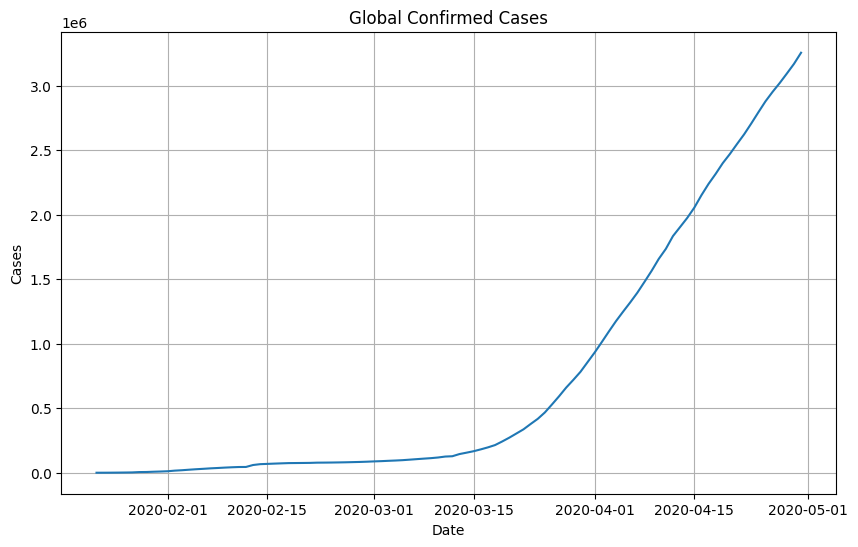

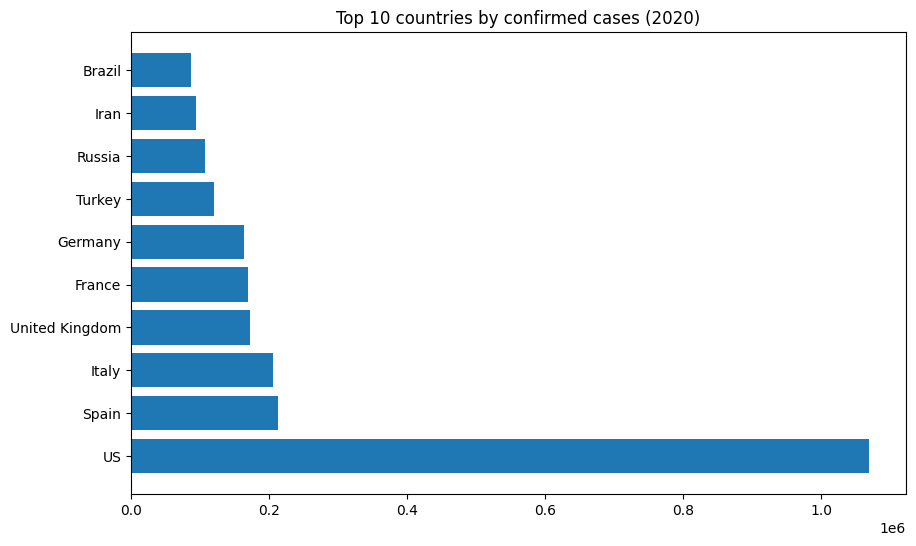

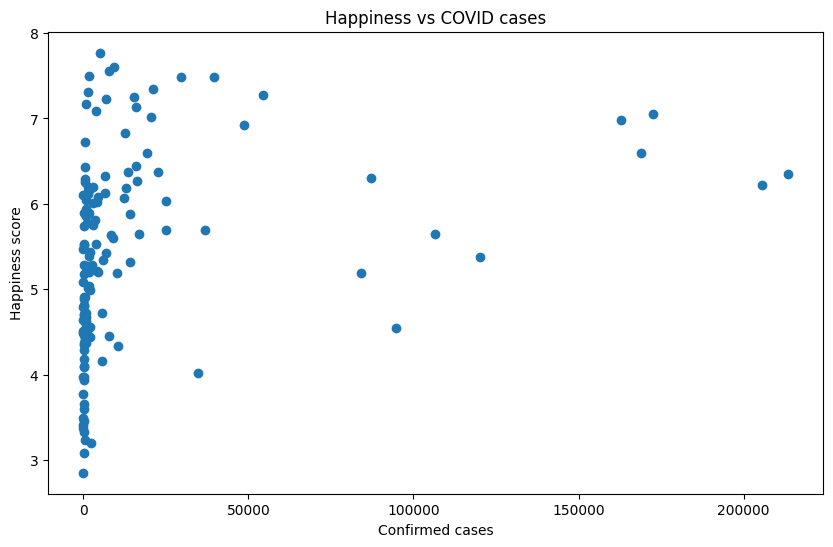

In [22]:
# Global cumulative
global_cases = covid.groupby('Date')['Confirmed'].sum()
plt.plot(global_cases.index, global_cases.values)
plt.title("Global Confirmed Cases")
plt.xlabel("Date"); plt.ylabel("Cases"); plt.grid(True)
plt.show()

# Top 10 countries latest year
latest_year = covid['Year'].max()
top10 = merged[merged['Year']==latest_year].nlargest(10,'Confirmed_total')
plt.barh(top10['Country'], top10['Confirmed_total'])
plt.title(f"Top 10 countries by confirmed cases ({latest_year})")
plt.show()

# Scatter happiness vs cases
df_scatter = merged.dropna(subset=['Happiness_Score'])
plt.scatter(df_scatter['Confirmed_total'], df_scatter['Happiness_Score'])
plt.xlabel("Confirmed cases"); plt.ylabel("Happiness score")
plt.title("Happiness vs COVID cases")
plt.show()


Simple correlation

In [23]:
if 'Happiness_Score' in merged.columns:
    r, p = pearsonr(merged['Confirmed_total'].fillna(0), merged['Happiness_Score'].fillna(0))
    print(f"Pearson correlation between cases and happiness: r={r:.3f}, p={p:.3e}")


Pearson correlation between cases and happiness: r=-0.002, p=9.836e-01
